<a id="loading_data"></a>
### Loading data

In [1]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import warnings

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
train = pd.read_csv("train_curated.csv")
test = pd.read_csv("sample_submission.csv")
noisy = pd.read_csv('train_noisy.csv')

In [3]:
train.head()

,fname,labels
0,0006ae4e.wav,Bark
1,0019ef41.wav,Raindrop
2,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,Run
4,0026f116.wav,Finger_snapping


In [4]:
test.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,426eb1e0.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,428d70bb.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4292b1c9.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,429c5071.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
noisy.head()

,fname,labels
0,00097e21.wav,Bathtub_(filling_or_washing)
1,000b6cfb.wav,Motorcycle
2,00116cd2.wav,"Marimba_and_xylophone,Glockenspiel"
3,00127d14.wav,"Water_tap_and_faucet,Sink_(filling_or_washing)"
4,0019adae.wav,Raindrop


In [6]:
print("Number of train examples=", train.shape[0], "  Number of classes=", len(set(train.labels)))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))
print("Number of noisy examples=", noisy.shape[0], "  Number of classes=", len(set(noisy.labels)))

Number of train examples= 4970   Number of classes= 213
Number of test examples= 3361   Number of classes= 80
Number of noisy examples= 19815   Number of classes= 1168


The number of single labels is actually only 80 but it shows 213 in train because there are multiple labels for some samples.

<a id="distribution"></a>
### Distribution of Categories

Only considering labels that are also in test data

In [7]:
train = train[train.labels.isin(test.columns[1:])]
print(len(train))

4269


In [8]:
noisy = noisy[noisy.labels.isin(test.columns[1:])]
print(len(noisy))

16566


In [9]:
categories_counts = train.groupby(['labels']).count()
categories_counts.columns = ['counts']
print(len(categories_counts))

74


In [10]:
categories_counts = noisy.groupby(['labels']).count()
categories_counts.columns = ['counts']
print(len(categories_counts))

80


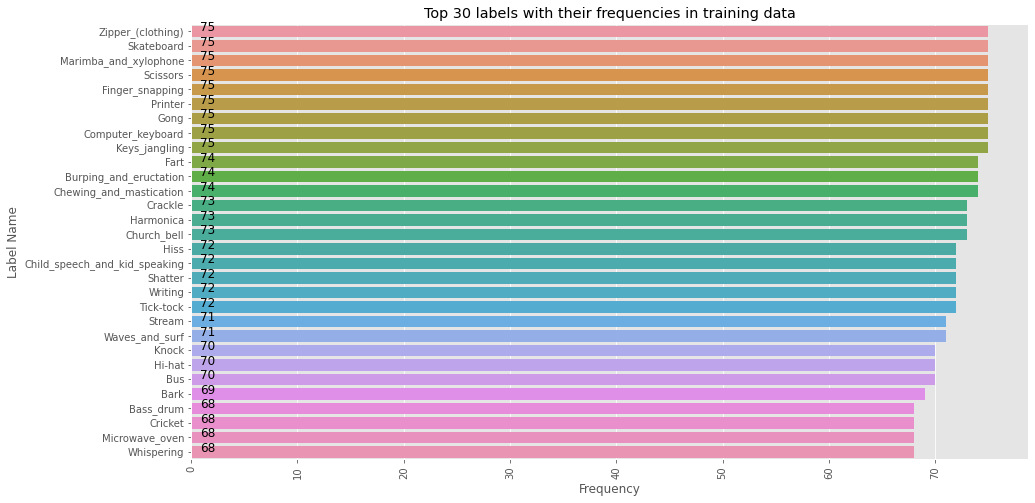

In [11]:
plt.figure(figsize=(15,8))
audio_type = train['labels'].value_counts().head(30)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in training data")
plt.show()

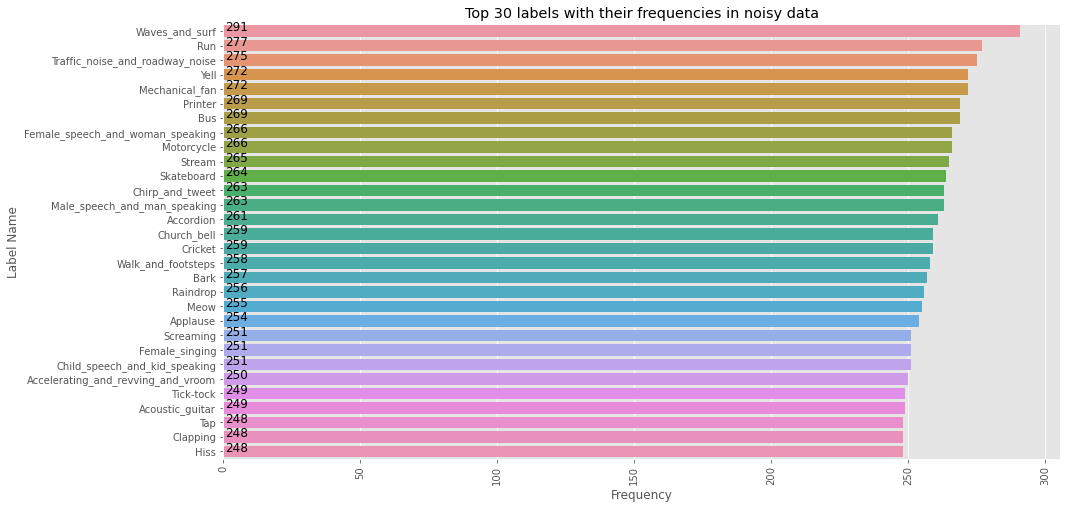

In [12]:
plt.figure(figsize=(15,8))
audio_type = noisy['labels'].value_counts().head(30)
sns.barplot(audio_type.values, audio_type.index)
for i, v in enumerate(audio_type.values):
    plt.text(0.8,i,v,color='k',fontsize=12)
plt.xticks(rotation='vertical')
plt.xlabel('Frequency')
plt.ylabel('Label Name')
plt.title("Top 30 labels with their frequencies in noisy data")
plt.show()

In [13]:
print('Minimum samples per category in train data = ', min(train.labels.value_counts()))
print('Maximum samples per category in train data = ', max(train.labels.value_counts()))
print('Minimum samples per category in noisy data = ', min(noisy.labels.value_counts()))
print('Maximum samples per category in noisy data = ', max(noisy.labels.value_counts()))

Minimum samples per category in train data =  3
Maximum samples per category in train data =  75
Minimum samples per category in noisy data =  28
Maximum samples per category in noisy data =  291


The number of unique categories is much higher in noisy data, this is because of the presence of simultaneous events in a single clip which result in multi labelled clips that are treated as unique categories in pandas.

### Reading Audio Files

In [25]:
import IPython.display as ipd 
fname = 'train_curated/0019ef41.wav'   # Raindrop
ipd.Audio(fname)

In [26]:
# Using wave library
import wave
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  90616
Duration =  2.054784580498866


This means that in the audio files we have 44100 samples per second.

In [38]:
raindrop = 'train_curated/'+train.loc[train['labels'] == 'Raindrop', 'fname'].iloc[0]
bark = 'train_curated/'+train.loc[train['labels'] == 'Bark', 'fname'].iloc[0]
run = 'train_curated/'+train.loc[train['labels'] == 'Run', 'fname'].iloc[0]
meow = 'train_curated/'+train.loc[train['labels'] == 'Meow', 'fname'].iloc[0]

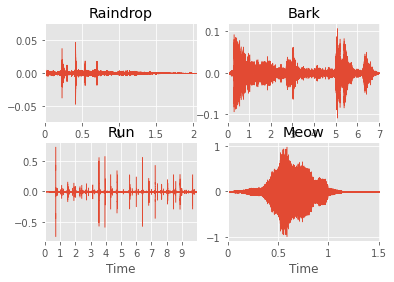

In [46]:
plt.subplot(2, 2, 1)
y, sr = librosa.load(raindrop, duration=10)
plt.title('Raindrop')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 2)
y, sr = librosa.load(bark, duration=10)
plt.title('Bark')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 3)
y, sr = librosa.load(run, duration=10)
plt.title('Run')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 4)
y, sr = librosa.load(meow, duration=10)
plt.title('Meow')
librosa.display.waveplot(y, sr=sr)

In [29]:
# getting a sample for the same type of audio from noisy data
fname = 'train_noisy/0019adae.wav'
wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  661500
Duration =  15.0


In [48]:
raindrop = 'train_noisy/'+noisy.loc[noisy['labels'] == 'Raindrop', 'fname'].iloc[0]
bark = 'train_noisy/'+noisy.loc[noisy['labels'] == 'Bark', 'fname'].iloc[0]
run = 'train_noisy/'+noisy.loc[noisy['labels'] == 'Run', 'fname'].iloc[0]
meow = 'train_noisy/'+noisy.loc[noisy['labels'] == 'Meow', 'fname'].iloc[0]

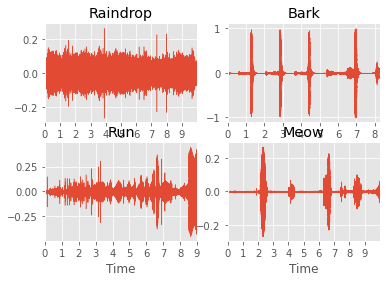

In [49]:
plt.subplot(2, 2, 1)
y, sr = librosa.load(raindrop, duration=10)
plt.title('Raindrop')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 2)
y, sr = librosa.load(bark, duration=10)
plt.title('Bark')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 3)
y, sr = librosa.load(run, duration=10)
plt.title('Run')
librosa.display.waveplot(y, sr=sr)

plt.subplot(2, 2, 4)
y, sr = librosa.load(meow, duration=10)
plt.title('Meow')
librosa.display.waveplot(y, sr=sr)

Plotting the waveplots for same audio event for both noisy and curated sets shows considerably different plots. This shows that along with the target event many other events might also be present in the noisy data making it much less usable.

<a id="audio_length"></a>
### Audio Length

Getting lengths of audio files

In [ ]:
train['nframes'] = train['fname'].apply(lambda f: wave.open('train_curated/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open('test/' + f).getnframes())
noisy['nframes'] = noisy['fname'].apply(lambda f: wave.open('train_noisy/' + f).getnframes())

In [58]:
train.head()

,fname,labels,nframes
0,0006ae4e.wav,Bark,310456
1,0019ef41.wav,Raindrop,90616
2,001ec0ad.wav,Finger_snapping,66976
3,0026c7cb.wav,Run,1125886
4,0026f116.wav,Finger_snapping,60638


In [59]:
noisy.head()

,fname,labels,nframes
0,00097e21.wav,Bathtub_(filling_or_washing),661500
1,000b6cfb.wav,Motorcycle,661500
4,0019adae.wav,Raindrop,661500
5,001b819d.wav,Bass_guitar,661500
9,0020becb.wav,Harmonica,687104


Plotting for top 25 frames

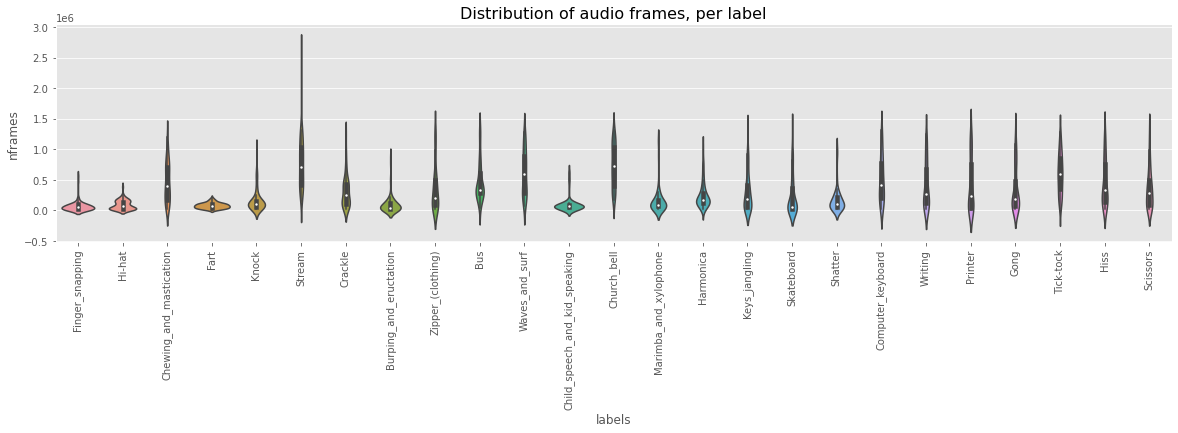

In [26]:
idx_sel = categories_counts.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train[(train.labels.isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

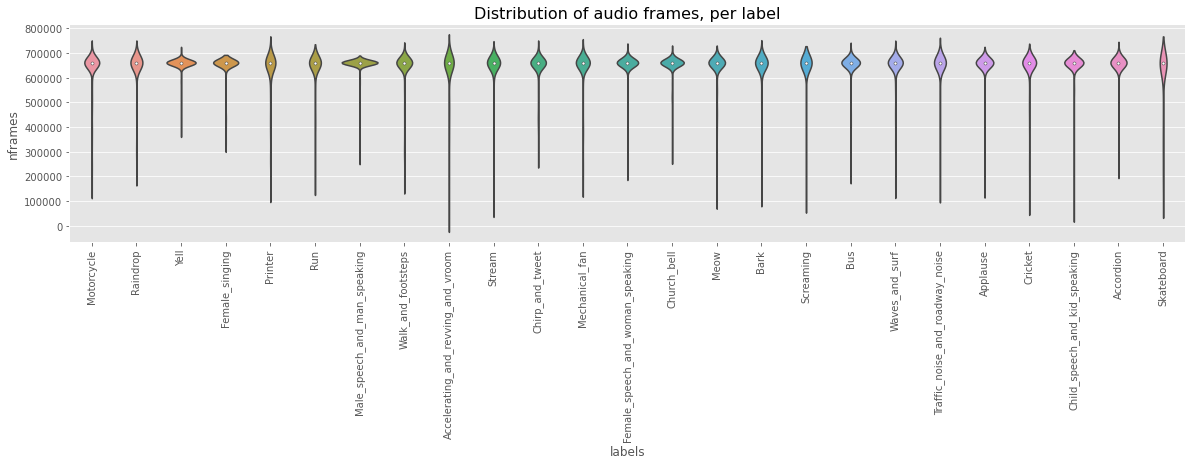

In [60]:
idx_sel = categories_counts.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=noisy[(noisy.labels.isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

The distribution of audio length across labels is non uniform and has high variance. In case of curated data, the audio frames are usually very small in length while noisy data is much longer. Both have high variances but curated seem to have generally a higher variance than noisy data.

### Analyzing the frame length distribution in train and test.

In [88]:
noisy.sort_values(by=['nframes'],ascending=False)

,fname,labels,nframes
10864,8c2ef0d6.wav,Fill_(with_liquid),705536
12907,a5b5e236.wav,Chirp_and_tweet,705536
4834,3e1925ff.wav,Accelerating_and_revving_and_vroom,705536
11402,92f0d33a.wav,Frying_(food),704512
5418,45d85d43.wav,Toilet_flush,704512
...,...,...,...
2880,24e849fb.wav,Burping_and_eructation,49152
11559,9522fa35.wav,Crackle,47104
8799,715787b2.wav,Accelerating_and_revving_and_vroom,46080
5266,43c5f52a.wav,Accelerating_and_revving_and_vroom,46080


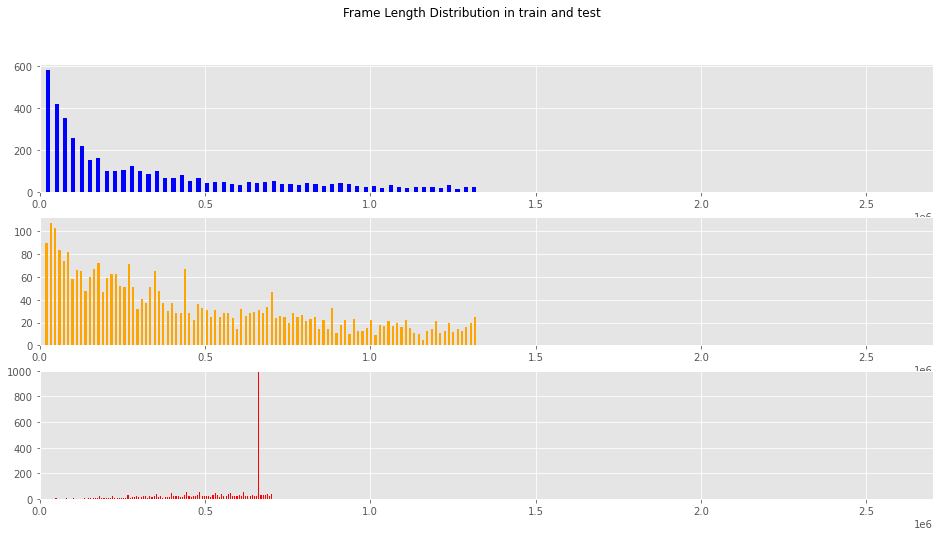

In [97]:
fig, ax = plt.subplots(3, 1, figsize=(16,8))
train.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='blue')
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='orange')
noisy.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[2], color='red')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
ax[2].set_xlim(0, 2700000)
ax[2].set_ylim(0, 1000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');

In noisy data, a diproportionate number of points have the same n_frames which is why we see a large line going across vertically. We can also note that in train and test data, most clips are shorter in length but in noisy data the number of clips increases as we go further which means the clips are usually much longer in length.